# Import python dataset

In [1]:
k = 821
notebookName = 'DCGAN.ipynb'

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

import numpy as np
import functools
import time



import keras
from keras.optimizers import Adam
from tensorflow import reduce_mean
import gc
from sklearn.preprocessing import *


from tensorflow.python.client import device_lib
import joblib
import matplotlib.ticker as mticker

In [3]:
tf.config.run_functions_eagerly(True)
allow_pickle=True

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4275987148787185060
]
Num GPUs Available:  0


In [5]:
os.makedirs('./output/Figures')
os.makedirs('./output/Figures/Individual')
os.makedirs('./output/Figures/Result')
os.makedirs('./output/Figures/Prediction')
os.makedirs('./ganmodedls')
os.makedirs('./logs/reconstrunction_log_dir')
os.makedirs('./logs/generator')
os.makedirs('./logs/discriminator')
os.makedirs('./output/Figures/Loss')

## Load data

In [6]:
n_features = 7

In [7]:
data01= np.loadtxt('../input/pollutant/01.txt') 
print(data01.shape)

data02= np.loadtxt('../input/pollutant/02.txt') 
print(data02.shape)

data04= np.loadtxt('../input/pollutant/04.txt') 
print(data04.shape)


groups = ['PM10','PM2_5', 'PM1', 'CO2' ,'Temeprature' ,'RH']
groups = np.array(groups)
print(groups.shape)

groups2 = ['times','PM10','PM2_5', 'PM1', 'CO2' ,'Temeprature' ,'RH']
groups2 = np.array(groups2)
print(groups2.shape)

with open("../input/pollutant/10_2_time.csv", "r", encoding="utf-8") as fr:
    times = [fr.readlines()]
    
times = np.array(times)
times = times.T

print('times = ',times[:,0].shape)
print(times[0,:])

(1419, 7)
(1419, 7)
(1419, 7)
(6,)
(7,)
times =  (1419,)
['00:10\n']


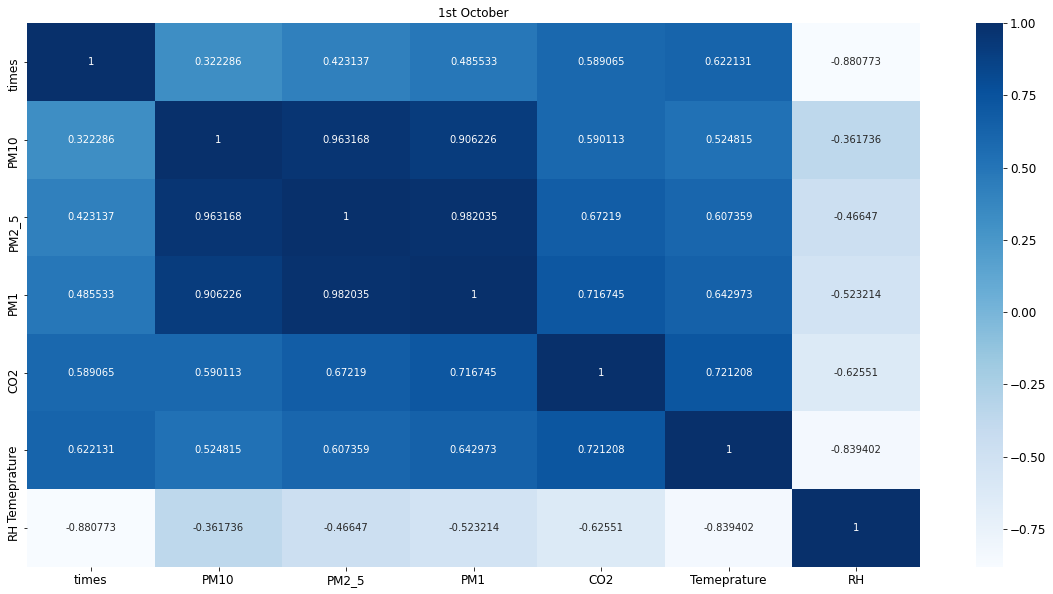

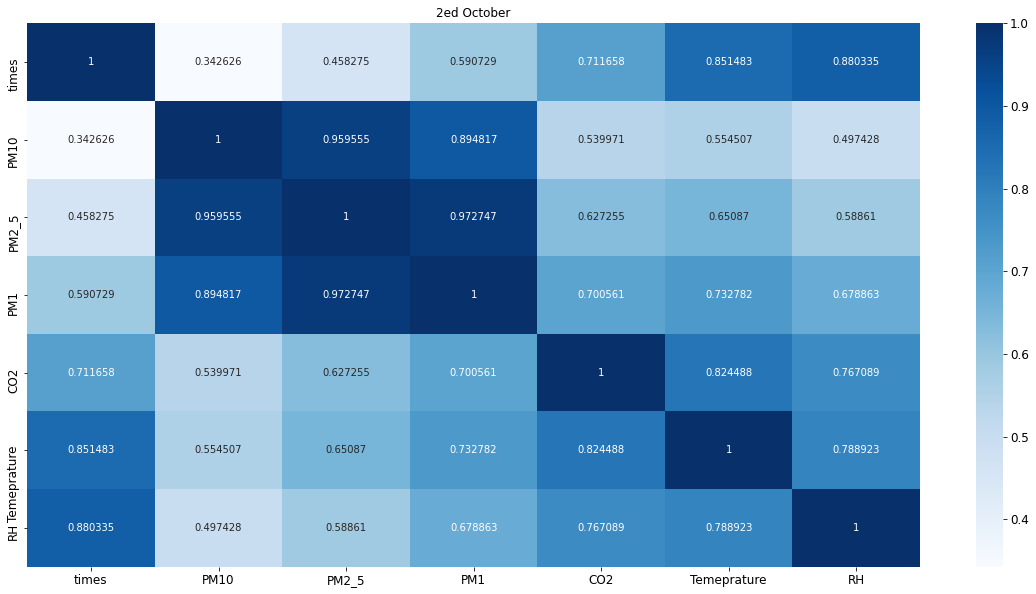

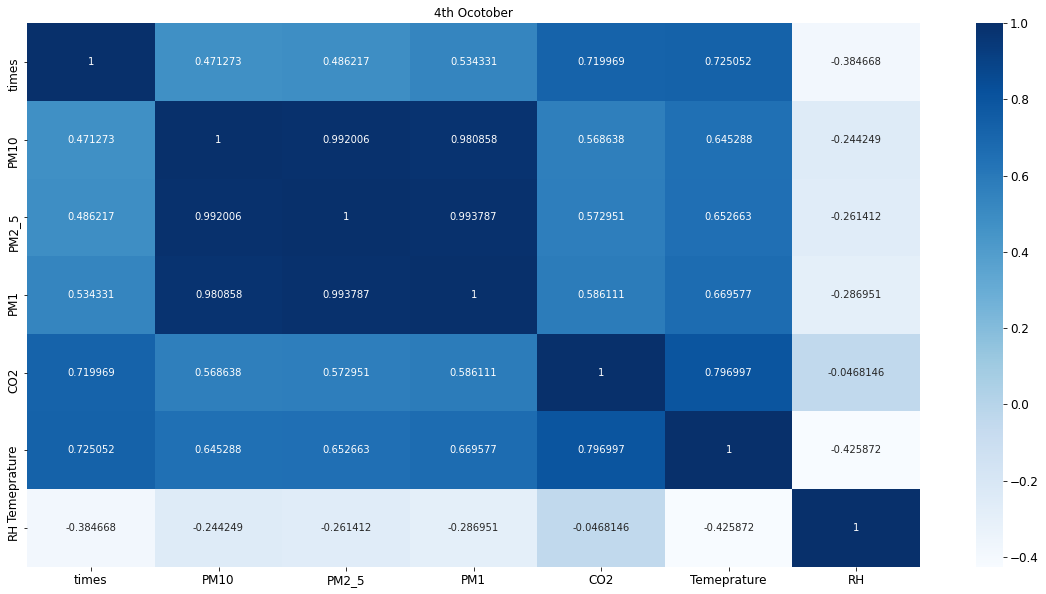

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#X_train_concat = X_train_concat.reshape(-1,7)
data01 = np.array([data01[:,0],data01[:,1],data01[:,2],data01[:,3],data01[:,4],data01[:,5],data01[:,6]])
covMatrix = np.corrcoef(data01)
fig, ax = plt.subplots(figsize=(20,10)) 

# create seabvorn heatmap with required labels
sns.heatmap(covMatrix, annot=True, fmt='g',cmap="Blues", ax=ax, xticklabels=groups2, yticklabels=groups2)
plt.title('1st October')
plt.savefig('./output/Figures/Result/Covariance_01_v'+str(k)+'.png')
plt.show()



data02 = np.array([data02[:,0],data02[:,1],data02[:,2],data02[:,3],data02[:,4],data02[:,5],data02[:,6]])
covMatrix = np.corrcoef(data02)
fig, ax = plt.subplots(figsize=(20,10)) 

# create seabvorn heatmap with required labels
sns.heatmap(covMatrix, annot=True, fmt='g',cmap="Blues", ax=ax, xticklabels=groups2, yticklabels=groups2)
plt.title('2ed October')
plt.savefig('./output/Figures/Result/Covariance_02_v'+str(k)+'.png')
plt.show()


data04 = np.array([data04[:,0],data04[:,1],data04[:,2],data04[:,3],data04[:,4],data04[:,5],data04[:,6]])
covMatrix = np.corrcoef(data04)
fig, ax = plt.subplots(figsize=(20,10)) 

# create seabvorn heatmap with required labels
sns.heatmap(covMatrix, annot=True, fmt='g',cmap="Blues", ax=ax, xticklabels=groups2, yticklabels=groups2)
plt.title('4th Ocotober')
plt.savefig('./output/Figures/Result/Covariance_04_v'+str(k)+'.png')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[20,10]) 
ax.plot(times[:,0], data02[:,1], label='CO2') 
ax.plot(times[:,0], data02[:,2], label='PM10') 
ax.plot(times[:,0], data02[:,3], label='PM2.5') 
ax.plot(times[:,0], data02[:,4], label='PM1')

myLocator = mticker.MultipleLocator(200)
ax.xaxis.set_major_locator(myLocator)


ax.grid() 
plt.ylabel("concentration (ppm)") 
plt.xlabel("time (min)") 
plt.title('2ed Oct. CO2&PM') 
plt.legend()
plt.savefig('./output/Figures/Sample_CO2+PM_02'+str(k)+'.png') 

fig, ax = plt.subplots(1,1, figsize=[10,5]) 
ax.plot(times[:,0], data02[:,5],c='black', label='Temperature') 

myLocator = mticker.MultipleLocator(200)
ax.xaxis.set_major_locator(myLocator)



ax.grid() 
plt.ylabel("Fahrenheit(F)") 
plt.xlabel("time (min)") 
plt.title('2ed Oct. Temperature') 
plt.legend()
plt.savefig('./output/Figures/Sample_Temp_02'+str(k)+'.png') 

fig, ax = plt.subplots(1,1, figsize=[10,5]) 
ax.plot(times[:,0], data02[:,6],c='black', label='RH') #what is the unit? 

myLocator = mticker.MultipleLocator(200)
ax.xaxis.set_major_locator(myLocator)


ax.grid() 
plt.ylabel("RH(%)") 
plt.xlabel("time (min)") 
plt.title('2ed Oct. Humidity') 
plt.legend()

plt.savefig('./output/Figures/Sample_RH_02'+str(k)+'.png') 
plt.show

# Preparing Dataset

In [ ]:
codings_size = n_features

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=[-1,1])
X_train_scaled = scaler.fit_transform(data02)

X_train_scaled.shape 


In [ ]:
#scaler inverse_transform
X_train = scaler.inverse_transform(((X_train_scaled)))
X_train.shape 

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    #a=i+1
    ax.flatten()[i].plot(X_train[:,0], X_train[:,i+1])
    ax.flatten()[i].set_title(group)
plt.savefig('./output/Figures/Individual/Sample'+'_v'+str(k)+'.png')

# Preparing the training dataset

In [ ]:
n = 500

In [ ]:
def concat_timesteps(X_train_scaled, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train_scaled) - ntimes*step):
        X_train_concat.append(X_train_scaled[i:i+ntimes*step:step])
    return np.array(X_train_concat)

ntimes = 100 # Consecutive times for the GAN
step = 1 # step between times (1 mins)

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)#X_train_scaled
X_train_concat = X_train_concat.reshape(X_train_concat.shape[0],ntimes,n_features,1)
print(X_train_concat.shape)
#Individual sample dataset


print(X_train_concat[n].shape)
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_concat[n][:,0,-1], X_train_concat[n][:,i+1,-1], '-o')
    ax.flatten()[i].set_title(group)
    ax.flatten()[0].set_xlabel("time step")
    ax.flatten()[0].set_ylabel("concentration (ppm)")



In [ ]:
BATCH_SIZE = 256
latent_space = 50

# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], ntimes, n_features,1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_scaled))
train_dataset = train_dataset.batch(BATCH_SIZE)

for data in train_dataset:
    print(data.shape)
    break

In [ ]:
gan = tf.keras.models.load_model('../input/ganmodels/ganmodels/DCGAN_v1_epoch_10000.h5', compile=False).layers
generator, discriminator = tf.keras.models.load_model('../input/ganmodels/ganmodels/DCGAN_v1_epoch_10000.h5', compile=False).layers  

In [ ]:
X_train_concat_flatten2 = X_train_concat.reshape(X_train_concat.shape[0]*ntimes, n_features).astype('float32')
X_train_concat_flatten2 = scaler.inverse_transform(X_train_concat_flatten2)


fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_concat_flatten2[:,0],X_train_concat_flatten2[:,i+1],'o')
    ax.flatten()[i].set_title('2ed Oct.')
    ax.flatten()[0].set_xlabel("time step")
    ax.flatten()[0].set_ylabel("concentration (ppm)")    
    
plt.savefig('./output/Figures/02_sample_v'+str(k)+'.png')



# Predict with the GAN

## Predict one point (start at n=500)

In [ ]:
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)

#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
n = 500
epochs = 50000



epoch=30000 #model's epoch

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(2e-2) #1e-4

def mse_loss(inp, outp):
    inp = tf.reshape(inp, [-1, n_features]) 
    outp = tf.reshape(outp, [-1, n_features])
    print("input:",inp.shape)
    print("output:",outp.shape)
    
    return mse(inp, outp)

In [ ]:
@tf.function
def opt_step(latent_values, real_coding):
    #with tpu_strategy.scope():
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:])   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss



def optimize_coding(real_coding):
    latent_values = tf.random.normal([len(real_coding), latent_space])  
    latent_values = tf.Variable(latent_values) #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(epochs): #20000
        loss.append(opt_step(latent_values, real_coding).numpy())
        
    plt.plot(loss)
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output


X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], n_features*ntimes).astype('float32')

n = n #n=100
real_coding = X_train_concat_flatten[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)


latent_values = optimize_coding(real_coding)


print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:], real_coding).numpy())


print(latent_values)

In [ ]:
X_generated = generator(latent_values).numpy()
X_generated = scaler.inverse_transform((X_generated.reshape(ntimes, n_features)))
print('X_generated : ',X_generated.shape)


X_real = scaler.inverse_transform((X_train_concat_flatten[n].reshape(ntimes,n_features)))
X_real = X_real.reshape(ntimes, n_features)
print('X_real : ',X_real.shape)


fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train[n:(n+ntimes),i+1], '-o', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-o',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()


plt.savefig('./output/Figures/Prediction/02_one_point_v'+str(k)+'_epoch_'+str(epoch)+'.png')

# Predict the whole simulation

In [ ]:
epochs3 = 10000
predict_points = X_train.shape[0]-n-ntimes

In [ ]:
def optimize_coding(latent_values, real_coding, epochs=epochs3):
    
    for epoch in range(epochs):
        opt_step(latent_values, real_coding)
        
    return latent_values  #returns the optimized input that generates the desired output


@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[-1,:(ntimes - 1),:])   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss


np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs=epochs3)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [ ]:
X_generated = scaler.inverse_transform((X_predict))
print(X_generated.shape)
X_generated = X_generated.reshape(len(X_predict), n_features)
X_generated[X_generated<0] = 0 
                                       

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title('2nd. Oct.') 
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/02_entire'+'_v'+str(k)+'_epoch_'+str(epoch)+'.png')

# 10/04

In [ ]:
scaler = MinMaxScaler(feature_range=[-1,1])
X_train_scaled = scaler.fit_transform(data04)

#scaler inverse_transform
X_train = scaler.inverse_transform(((X_train_scaled)))
X_train.shape 

In [ ]:
def concat_timesteps(X_train_scaled, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train_scaled) - ntimes*step):
        X_train_concat.append(X_train_scaled[i:i+ntimes*step:step])
    return np.array(X_train_concat)

ntimes = 100 # Consecutive times for the GAN
step = 1 # step between times (1 mins)

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)#X_train_scaled
X_train_concat = X_train_concat.reshape(X_train_concat.shape[0],ntimes,n_features,1)
print(X_train_concat.shape)
    

In [ ]:
X_train_concat_flatten2 = X_train_concat.reshape(X_train_concat.shape[0]*ntimes, n_features).astype('float32')
X_train_concat_flatten2 = scaler.inverse_transform(X_train_concat_flatten2)


fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train_concat_flatten2[:,0],X_train_concat_flatten2[:,i+1],'o')
    ax.flatten()[i].set_title(group)
    ax.flatten()[0].set_xlabel("time step")
    ax.flatten()[0].set_ylabel("concentration (ppm)")    
    
plt.savefig('./output/Figures/sample_04_v'+str(k)+'.png')

## One Point

In [ ]:
epochs = 50000

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(2e-2) #1e-4

def mse_loss(inp, outp):
    inp = tf.reshape(inp, [-1, n_features]) 
    outp = tf.reshape(outp, [-1, n_features])
    print("input:",inp.shape)
    print("output:",outp.shape)
    
    return mse(inp, outp)

In [ ]:
@tf.function
def opt_step(latent_values, real_coding):
    #with tpu_strategy.scope():
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:])   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss



def optimize_coding(real_coding):
    latent_values = tf.random.normal([len(real_coding), latent_space])  
    latent_values = tf.Variable(latent_values) #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(epochs): #20000
        loss.append(opt_step(latent_values, real_coding).numpy())
        
    plt.plot(loss)
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output


X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], n_features*ntimes).astype('float32')

n = n #n=100
real_coding = X_train_concat_flatten[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)


latent_values = optimize_coding(real_coding)


print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:], real_coding).numpy())


print(latent_values)

In [ ]:
X_generated = generator(latent_values).numpy()
X_generated = scaler.inverse_transform((X_generated.reshape(ntimes, n_features)))
print('X_generated : ',X_generated.shape)


X_real = scaler.inverse_transform((X_train_concat_flatten[n].reshape(ntimes,n_features)))
X_real = X_real.reshape(ntimes, n_features)
print('X_real : ',X_real.shape)


fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train[n:(n+ntimes),i+1], '-o', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-o',c='orange', label='generated')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend()


plt.savefig('./output/Figures/Prediction/04_one_point_v'+str(k)+'_epoch_'+str(epoch)+'.png')

# All Day

In [ ]:
epochs3 = 10000
predict_points = X_train.shape[0]-n-ntimes

In [ ]:
def optimize_coding(latent_values, real_coding, epochs=epochs3):
    
    for epoch in range(epochs):
        opt_step(latent_values, real_coding)
        
    return latent_values  #returns the optimized input that generates the desired output


@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[-1,:(ntimes - 1),:])   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss


np.random.seed(0)
tf.random.set_seed(0)

real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

latent_values = optimize_coding(latent_values, real_coding, epochs=epochs3)
X_predict = list(generator(latent_values).numpy().reshape(-1,n_features))
gen_predict = X_predict[-1]
real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,n_features:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(predict_points): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, epochs)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [ ]:
X_generated = scaler.inverse_transform((X_predict))
print(X_generated.shape)
X_generated = X_generated.reshape(len(X_predict), n_features)
X_generated[X_generated<0] = 0 
                                       

fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_train[n:(n+ntimes+predict_points),i+1], '-', label='real')
    ax.flatten()[i].plot(X_generated[:,i+1], '-',c='orange', label='generated')
    ax.flatten()[i].set_title('2nd. Oct.') 
    ax.flatten()[i].legend()
    
plt.savefig('./output/Figures/Prediction/04_entire'+'_v'+str(k)+'_epoch_'+str(epoch)+'.png')